## Importando bibliotecas necessárias

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Utilizado para data augmentation
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
tf.__version__

'2.6.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carregamento da base de dados

In [ ]:
#Montando meu google drive com as imagens
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Dividindo os conjuntos de treino e teste com *data augmentation***

Conjunto de treinamento

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                   rotation_range = 50,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True)

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/data/datamining-rx/train',
                                                    target_size = (224, 224),
                                                    batch_size = 16,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

Found 312 images belonging to 2 classes.


In [ ]:
train_generator.n # Retorna o número de imagens

312

In [ ]:
train_generator.batch_size # Retorna o número do lote de atualizações das imagens, com intuito de atualizar os pesos da rede

16

In [ ]:
# Passo do treinamento
step_size_train = train_generator.n // train_generator.batch_size
step_size_train

19

Conjunto de teste

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [ ]:
test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/data/datamining-rx/test',
                                                  target_size = (224, 224),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 80 images belonging to 2 classes.


In [ ]:
step_size_test = test_generator.n // test_generator.batch_size
step_size_test

80

## Criando o modelo de Transfer Learning - ResNet50

In [ ]:
def create_model():

  base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top=False)

  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dense(256, activation='relu')(x)

  preds = tf.keras.layers.Dense(2, activation='softmax')(x)

  model = tf.keras.Model(inputs = base_model.input, outputs = preds)

  model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
#Visualizando camadas
for i, layer in enumerate(model.layers):
  print(i, layer.name)

0 input_2
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [ ]:
#Congelando camadas da ResNet50, para utilizar com os pesos já treinados
for layer in model.layers[:175]:
  layer.trainable = False

In [ ]:
#Descongelando a parte personalizada, criada acima com as camadas densas
for layer in model.layers[175:]:
  layer.trainable = True

In [ ]:
#Treinando a rede com os parâmetros
import pandas as pd

epochs = 100
loops = 1
history = {}

for i in range(loops):
  print('Ciclo: ', i+1)
  print()
  #model = create_model()
  history = model.fit_generator(generator = train_generator,
                              epochs = epochs,
                              steps_per_epoch = step_size_train,
                              validation_data = test_generator,
                              validation_steps = step_size_test,
                              verbose = 0)

Ciclo:  1



/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


# Avaliação da rede

## Gráficos

In [ ]:
#Acurácia
np.mean(history.history['val_accuracy'])

0.6983750006556511

In [ ]:
np.std(history.history['val_accuracy'])

0.11238403757194775

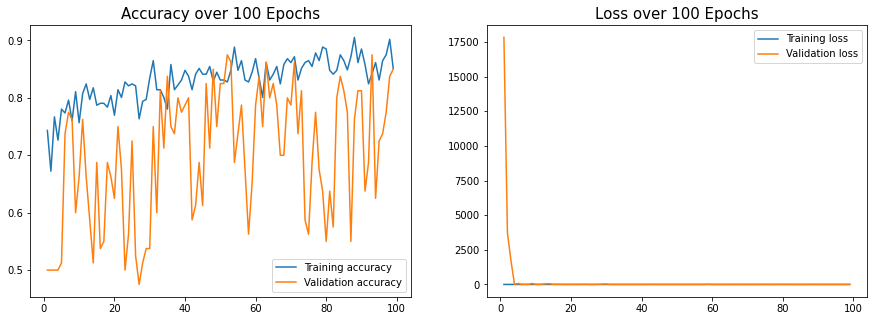

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = 100
def plot_acc_loss(history, epochs):

 acc = history.history['accuracy']
 loss = history.history['loss']
 val_acc = history.history['val_accuracy']
 val_loss = history.history['val_loss']
 plt.figure(figsize=(15, 5))

 plt.subplot(121)
 plt.plot(range(1,epochs), acc[1:], label='Training accuracy')
 plt.plot(range(1,epochs), val_acc[1:], label='Validation accuracy')
 plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
 plt.legend()
 #plt.grid(True)

 plt.subplot(122)
 plt.plot(range(1,epochs), loss[1:], label='Training loss')
 plt.plot(range(1,epochs), val_loss[1:], label='Validation loss')
 plt.title('Loss over ' + str(epochs) +  ' Epochs', size=15)
 plt.legend();
 #plt.grid(True)
 plt.show()

 
plot_acc_loss(history, epochs)
plt.savefig('curvas-rx.png', dpi=500) 

## Previsões

In [ ]:
#Pega todas as imagens do teste
filenames = test_generator.filenames
filenames

['COVID-19/1-s2.0-S1684118220300608-main.pdf-002.jpg',
 'COVID-19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-000-fig1a.png',
 'COVID-19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-001-fig2b.png',
 'COVID-19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-003-fig4b.png',
 'COVID-19/16660_4_1.jpg',
 'COVID-19/16663_1_1.jpg',
 'COVID-19/16664_1_1.jpg',
 'COVID-19/16669_3_1.jpeg',
 'COVID-19/16708_1_1.jpg',
 'COVID-19/16747_1_1.jpg',
 'COVID-19/16953_3_1.jpg',
 'COVID-19/16953_4_1.jpg',
 'COVID-19/16953_5_1.jpg',
 'COVID-19/41379_2020_536_Fig2_HTML-c1.png',
 'COVID-19/5f619d7e.jpg',
 'COVID-19/82a78c13.jpg',
 'COVID-19/88de9d8c39e946abd495b37cd07d89e5-2ee6-0.jpg',
 'COVID-19/8FDE8DBA-CFBD-4B4C-B1A4-6F36A93B7E87.jpeg',
 'COVID-19/90986ce4.jpg',
 'COVID-19/9C34AF49-E589-44D5-92D3-168B3B04E4A6.jpeg',
 'COVID-19/CD50BA96-6982-4C80-AE7B-5F67ACDBFA56.jpeg',
 'COVID-19/F4341CE7-73C9-45C6-99C8-8567A5484B63.jpeg',
 'COVID-19/FE9F9A5D-2830-46F9-851B-1FF4534959BE.jpeg',
 'COVID-19/a2eba651.jpg'

In [ ]:
len(filenames)

80

In [ ]:
predictions = model.predict(test_generator, steps = len(filenames))

In [ ]:
#Retorna as probabilidades
predictions

array([[9.5182478e-01, 4.8175171e-02],
       [9.9970275e-01, 2.9721655e-04],
       [9.8499829e-01, 1.5001707e-02],
       [9.9999332e-01, 6.6435978e-06],
       [9.9932230e-01, 6.7771034e-04],
       [9.8340917e-01, 1.6590886e-02],
       [9.7710073e-01, 2.2899313e-02],
       [9.7185326e-01, 2.8146660e-02],
       [9.8582274e-01, 1.4177297e-02],
       [9.9999630e-01, 3.7011664e-06],
       [9.9550003e-01, 4.4999067e-03],
       [9.9999690e-01, 3.1279133e-06],
       [9.9993145e-01, 6.8548914e-05],
       [1.0000000e+00, 3.5212600e-09],
       [9.5054102e-01, 4.9458973e-02],
       [9.9474514e-01, 5.2549322e-03],
       [9.5384240e-01, 4.6157643e-02],
       [9.9729580e-01, 2.7041771e-03],
       [8.4792012e-01, 1.5207990e-01],
       [9.7190362e-01, 2.8096329e-02],
       [9.9999094e-01, 9.0216063e-06],
       [7.3663890e-01, 2.6336113e-01],
       [9.9863166e-01, 1.3683465e-03],
       [9.8311645e-01, 1.6883623e-02],
       [9.9131703e-01, 8.6829150e-03],
       [9.9997294e-01, 2.

In [ ]:
predictions2 = []
for i in range(len(predictions)):
  predictions2.append(np.argmax(predictions[i]))

In [ ]:
predictions2

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0]

In [ ]:
#Fazendo previsão com as imagens reais
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
test_generator.class_indices

{'COVID-19': 0, 'Non-COVID-19': 1}

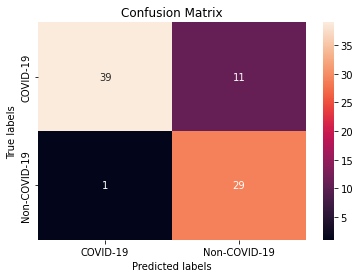

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     
from sklearn.metrics import accuracy_score, confusion_matrix


cm = confusion_matrix(predictions2, test_generator.classes)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

ax.xaxis.set_ticklabels(['COVID-19', 'Non-COVID-19']); 
ax.yaxis.set_ticklabels(['COVID-19', 'Non-COVID-19']);
plt.savefig('cm-rx.png', dpi=500)

In [ ]:
accuracy_score(predictions2, test_generator.classes)

0.85

## Plot Curva ROC

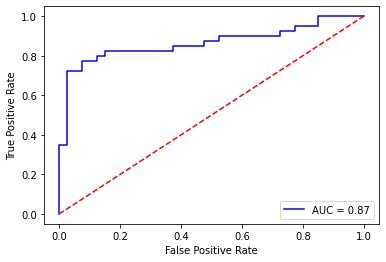

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

#Recuperando probabilidade da saída, somente da coluna
pred = predictions[:, 1]

#Resultados verdadeiros
y = test_generator.classes

fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
'''
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='')
display.plot()
plt.show()
'''
#plt.title('ROC curve CT images')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc-rx.png', dpi=500)
plt.show()